
## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import re
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, make_scorer

import lightgbm as lgb

from hyperopt.fmin import fmin
from hyperopt import hp, tpe

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true)) * 100)

## Анализ набора данных

In [4]:
df = pd.read_excel('Датасет НА.xlsx')

In [5]:
df.head()

,ID,Город,"Население, чел.",geo_lat,geo_lon,Вид актива,"Стоимость принятия на баланс за 1 кв.м, руб.","Площадь, кв.м","Стоимость приятия общая, руб.","Срок нахождения на балансе, мес.","Изменение цен на недвижимость в месяц, %","Рост цен всего, %","Расходы в месяц, руб.","Всего расходов, руб.","Накоплено расходов в момент переоценки, руб.","Переоценка стоимости, руб.","Стоимость реализации 1 кв.м, руб.","Общая стоимость реализации, руб.",Коэффициент дисконтирования,"Дисконтированная стоимость денежных потоков, руб.","Финансовый результат, руб.","Финансовый результат с учетом дисконтирования, руб.",Разница между результатами,Скидка на торг
0,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,123100.0,24620.0,3.223410e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117
1,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,750750.0,150150.0,5.111823e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220
2,3.0,Владимир,348256.0,56.128080,40.408438,Квартира 3-х комнатная,41158.0,59.0,2428322.0,12.0,0.584974,7.019684,30775.000000,369300.0,73860.0,2.462414e+06,44047.161700,2.598783e+06,0.892857,1.990609e+06,-1.988395e+05,-4.377126e+05,2.388731e+05,0.091917
3,4.0,Севастополь,393304.0,44.616701,33.525355,Частный дом до 150 кв.м,17549.0,129.0,2263821.0,12.0,0.210614,2.527372,5528.000000,66336.0,13267.2,2.275264e+06,17992.528560,2.321036e+06,0.892857,2.013125e+06,-9.120816e+03,-2.506958e+05,2.415750e+05,0.104081
4,5.0,Оренбург,570329.0,51.787509,55.101883,Квартира 1-но комнатная,50724.0,28.0,1420272.0,6.0,0.295859,1.775153,6312.000000,37872.0,7574.4,1.425314e+06,51624.428856,1.445484e+06,0.944911,1.330068e+06,-1.265999e+04,-9.020367e+04,7.754368e+04,0.053645


In [6]:
max_id = df['ID'].max()

In [7]:
arr = []
for i in range(1, max_id + 1):
    try:
        df_temp = df[df['ID'] == i]
        count_moun = df_temp['Срок нахождения на балансе, мес.'].iloc[0]
        df_temp['Текущий месяц'] = [round(x) for x in np.arange(0, count_moun + 1, count_moun / 4)]
        
        price_moun = df_temp['Расходы в месяц, руб.'].iloc[0]
        df_temp['Всего расходов, руб.'] = [round(x) * price_moun for x in np.arange(0, count_moun + 1, count_moun / 4)]
        arr.append(df_temp)
    except:
        print(i)

In [8]:
df = pd.concat(arr)

In [9]:
df.head(10)

,ID,Город,"Население, чел.",geo_lat,geo_lon,Вид актива,"Стоимость принятия на баланс за 1 кв.м, руб.","Площадь, кв.м","Стоимость приятия общая, руб.","Срок нахождения на балансе, мес.","Изменение цен на недвижимость в месяц, %","Рост цен всего, %","Расходы в месяц, руб.","Всего расходов, руб.","Накоплено расходов в момент переоценки, руб.","Переоценка стоимости, руб.","Стоимость реализации 1 кв.м, руб.","Общая стоимость реализации, руб.",Коэффициент дисконтирования,"Дисконтированная стоимость денежных потоков, руб.","Финансовый результат, руб.","Финансовый результат с учетом дисконтирования, руб.",Разница между результатами,Скидка на торг,Текущий месяц
0,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,0.0,24620.0,3.223410e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117,0
5038,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,30775.0,49240.0,3.236497e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117,3
10076,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,61550.0,73860.0,3.249583e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117,6
15114,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,92325.0,98480.0,3.262669e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117,9
20152,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,12.0,0.169847,2.038169,10258.333333,123100.0,123100.0,3.275756e+06,41996.869406,3.275756e+06,0.892857,2.814871e+06,-5.766819e+04,-3.954527e+05,3.377846e+05,0.103117,12
1,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,0.0,150150.0,5.111823e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220,0
5039,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,200200.0,300300.0,5.163509e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220,4
10077,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,400400.0,450450.0,5.215194e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220,8
15115,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,550550.0,600600.0,5.266880e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220,11
20153,2.0,Саратов,836900.0,51.530305,45.952935,Коммерческая до 1000 кв.м,52875.0,957.0,50601375.0,15.0,0.340475,5.107132,50050.000000,750750.0,750750.0,5.318565e+07,55575.396024,5.318565e+07,0.867916,4.550907e+07,1.833529e+06,-5.092306e+06,6.925835e+06,0.130220,15


In [10]:
df_save = df.copy()

## Подготовка данных

In [11]:
df = df[[
    'ID', 'Город', 'Население, чел.', 'geo_lat', 'geo_lon', 'Вид актива', 'Стоимость принятия на баланс за 1 кв.м, руб.',
    'Площадь, кв.м', 'Стоимость приятия общая, руб.', 'Расходы в месяц, руб.', 'Текущий месяц',
    
    'Переоценка стоимости, руб.', 'Всего расходов, руб.', 'Срок нахождения на балансе, мес.'
       
   ]]

In [12]:
df.head()

,ID,Город,"Население, чел.",geo_lat,geo_lon,Вид актива,"Стоимость принятия на баланс за 1 кв.м, руб.","Площадь, кв.м","Стоимость приятия общая, руб.","Расходы в месяц, руб.",Текущий месяц,"Переоценка стоимости, руб.","Всего расходов, руб.","Срок нахождения на балансе, мес."
0,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,0,3.223410e+06,0.0,12.0
5038,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,3,3.236497e+06,30775.0,12.0
10076,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,6,3.249583e+06,61550.0,12.0
15114,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,9,3.262669e+06,92325.0,12.0
20152,1.0,Нижний Тагил,361883.0,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,12,3.275756e+06,123100.0,12.0


## Унификация данных 

In [13]:
df = df.rename(columns={'geo_lat' : 'lat', 'geo_lon' : 'lon'})

## Очистка данных

In [14]:
df = df[~(df['Город'].isnull())]

## Преобразование типов

In [15]:
def str_to_float(s):
    s = str(s)
    s = s.replace(',00', '')
    s = s.replace(' ', '')
    
    return float(s)

In [16]:
df['Население, чел.'] = df['Население, чел.'].astype(int)

In [17]:
for col in df.columns[6:]:
    df[col] = df[col].apply(lambda x : str_to_float(x))

In [18]:
df.head()

,ID,Город,"Население, чел.",lat,lon,Вид актива,"Стоимость принятия на баланс за 1 кв.м, руб.","Площадь, кв.м","Стоимость приятия общая, руб.","Расходы в месяц, руб.",Текущий месяц,"Переоценка стоимости, руб.","Всего расходов, руб.","Срок нахождения на балансе, мес."
0,1.0,Нижний Тагил,361883,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,0.0,3.223410e+06,0.0,12.0
5038,1.0,Нижний Тагил,361883,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,3.0,3.236497e+06,30775.0,12.0
10076,1.0,Нижний Тагил,361883,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,6.0,3.249583e+06,61550.0,12.0
15114,1.0,Нижний Тагил,361883,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,9.0,3.262669e+06,92325.0,12.0
20152,1.0,Нижний Тагил,361883,57.910126,59.981285,Квартира 3-х комнатная,41158.0,78.0,3210324.0,10258.333333,12.0,3.275756e+06,123100.0,12.0


In [19]:
from sklearn import preprocessing

## Создание категориальных данных

In [20]:
le_city = preprocessing.LabelEncoder()
le_city.fit(df['Город'])
df['Город'] = le_city.transform(df['Город'])

le_ac = preprocessing.LabelEncoder()
le_ac.fit(df['Вид актива'])
df['Вид актива'] = le_ac.transform(df['Вид актива'])

# le.inverse_transform()

In [21]:
df.head()

,ID,Город,"Население, чел.",lat,lon,Вид актива,"Стоимость принятия на баланс за 1 кв.м, руб.","Площадь, кв.м","Стоимость приятия общая, руб.","Расходы в месяц, руб.",Текущий месяц,"Переоценка стоимости, руб.","Всего расходов, руб.","Срок нахождения на балансе, мес."
0,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,0.0,3.223410e+06,0.0,12.0
5038,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,3.0,3.236497e+06,30775.0,12.0
10076,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,6.0,3.249583e+06,61550.0,12.0
15114,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,9.0,3.262669e+06,92325.0,12.0
20152,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,12.0,3.275756e+06,123100.0,12.0


## Очистка данных от нечитаемых символов

In [22]:
def del_extra_char(s):
    s = s.replace('.', '')
    s = s.replace(',', '')
    s = s.replace('/', '')
    return s
    
    
df = df.rename(columns = lambda x:del_extra_char(x))

In [23]:
df

,ID,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб,Текущий месяц,Переоценка стоимости руб,Всего расходов руб,Срок нахождения на балансе мес
0,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,0.0,3.223410e+06,0.000000,12.0
5038,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,3.0,3.236497e+06,30775.000000,12.0
10076,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,6.0,3.249583e+06,61550.000000,12.0
15114,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,9.0,3.262669e+06,92325.000000,12.0
20152,1.0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,12.0,3.275756e+06,123100.000000,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,5038.0,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,0.0,5.942669e+06,0.000000,13.0
10075,5038.0,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,3.0,5.962731e+06,28727.142857,13.0
15113,5038.0,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,6.0,5.982792e+06,57454.285714,13.0
20151,5038.0,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,10.0,6.002854e+06,95757.142857,13.0


# Часть 1

## Прогноз срока нахождения актива на балансе

In [24]:
# Текущий месяц

In [25]:
feachers = list(df.columns[1:-3])
feachers.remove('Текущий месяц')

In [26]:
df['Текущий месяц'] = df['Текущий месяц'] + 1

## Функция для обучения модели

In [27]:
acc_params = dict()
plot_mape = []

def cross_vall_train(params, k_folds=3, target='Срок нахождения на балансе мес'):
    
    params = {
             'learning_rate' : params['learning_rate'],
             'min_child_samples' : int(params['min_child_samples']),
             'num_leaves': int(params['num_leaves']),
             'feature_fraction' : params['feature_fraction'],
             'bagging_fraction' : params['bagging_fraction'],
             'n_estimators' : int(params['n_estimators']),
         }      
    
    mape = []
    
    unique_filials = np.array(list(df['ID'].unique()))
    
    for sampling in (np.array_split(unique_filials, k_folds)):
        
        gbm = lgb.LGBMRegressor(
                                metric = 'mape',
                                min_data_per_group = 3,
                                reg_sqrt = True,
                                num_threads = -1,
                                objective = 'poisson',
                                bagging_freq = 5,
                                boost_from_average = True,
                                seed = 3,
        
                                **params
                                    )
        
        index_train = set(unique_filials) - set(sampling)
        
        X_train = (df[df['ID'].isin(index_train)]).sample(frac=1)
        Y_train = X_train[target]
        X_train = X_train[feachers]
        
        X_test = (df[df['ID'].isin(sampling)]).sample(frac=1)
        Y_test = X_test[target]
        X_test = X_test[feachers]

        model = gbm.fit( X_train, Y_train)
        pred = model.predict(X_test) 
        
        mape.append(mean_absolute_percentage_error(Y_test.values, pred))
        
    acc_params[np.round(np.mean(mape), 10)] = (params, np.mean(mape))
    plot_mape.append(np.mean(mape))
        
    return np.mean(mape)

In [28]:
space = {
     'learning_rate' : hp.quniform('learning_rate', 0.01, 0.75, 0.01),
     'min_child_samples' : hp.quniform('min_child_samples', 1, 15, 1),
     'num_leaves' : hp.quniform('num_leaves', 2, 10, 1),
     'feature_fraction' : hp.quniform('feature_fraction', 0.05, 0.75, 0.01),
     'bagging_fraction' : hp.quniform('bagging_fraction', 0.05, 0.9, 0.01),
     'n_estimators' : hp.quniform('n_estimators', 10, 500, 5)
}

best_period = fmin(fn=cross_vall_train,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_fraction is set=0.58, subsample=1.0 will be ignored. Current value: bagging_fraction=0.58 
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1                   
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5            
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_fraction is set=0.58, subsample=1.0 will be ignored. Current value: bagging_fraction=0.58 
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1                   
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5            
[LightGBM] [Warning] feature

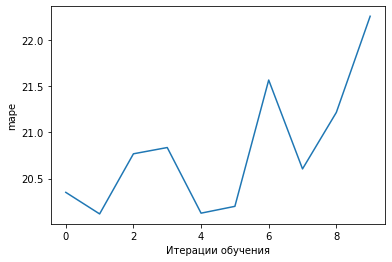

In [29]:
plt.plot(plot_mape)
plt.ylabel('mape')
plt.xlabel('Итерации обучения')
plt.show()

## Передача лучших параметров для обучения

In [30]:
lgbm_period = lgb.LGBMRegressor(
    bagging_fraction = best_period['bagging_fraction'],
    feature_fraction = best_period['feature_fraction'],
    learning_rate = best_period['learning_rate'],
    min_child_samples = int(best_period['min_child_samples']),
    n_estimators = int(best_period['n_estimators']),
    num_leaves = int(best_period['num_leaves']),
    
    num_threads = -1,
    objective = 'poisson',
    min_data_per_group = 3,
    reg_sqrt = True,
    bagging_freq = 5,
    boost_from_average = True,
    seed = 42)

## Обучение 

In [31]:
regressor_period = lgbm_period.fit(
    df[feachers],
    df['Срок нахождения на балансе мес']
)

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


## Shap

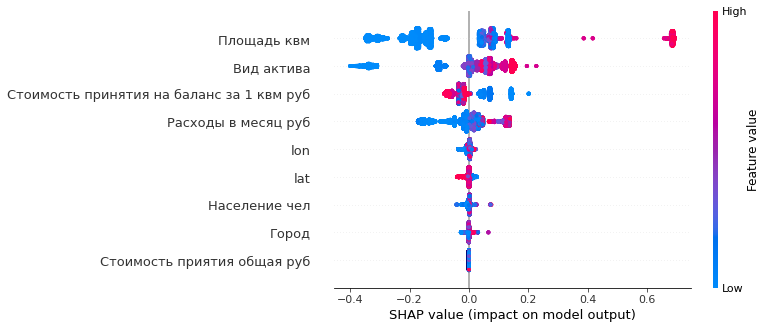

In [32]:
shap.initjs()
plt.figure(figsize=(15,15))
explainer = shap.TreeExplainer(regressor_period)
shap_values = explainer.shap_values(df[feachers])
fig = shap.summary_plot(shap_values, df[feachers], 
                        show=False, 
                        max_display=25)

# plt.savefig('..//images/123.png')

## Прогноз изменения стоимости актива

In [33]:
feachers = list(df.columns[1:-3]) 

In [34]:
feachers

['Город',
 'Население чел',
 'lat',
 'lon',
 'Вид актива',
 'Стоимость принятия на баланс за 1 квм руб',
 'Площадь квм',
 'Стоимость приятия общая руб',
 'Расходы в месяц руб',
 'Текущий месяц']

## Функция для обучения модели

In [35]:
acc_params = dict()
plot_mape = []

def cross_vall_train(params, k_folds=3, target='Переоценка стоимости руб'): 
    
    params = {
             'learning_rate' : params['learning_rate'],
             'min_child_samples' : int(params['min_child_samples']),
             'num_leaves': int(params['num_leaves']),
             'feature_fraction' : params['feature_fraction'],
             'bagging_fraction' : params['bagging_fraction'],
             'n_estimators' : int(params['n_estimators']),
         }      
    
    mape = []
    
    unique_filials = np.array(list(df['ID'].unique()))
    
    for sampling in (np.array_split(unique_filials, k_folds)):
        
        gbm = lgb.LGBMRegressor(
                                metric = 'mape',
                                min_data_per_group = 3,
                                reg_sqrt = True,
                                num_threads = -1,
                                objective = 'poisson',
                                bagging_freq = 5,
                                boost_from_average = True,
                                seed = 3,
        
                                **params
                                    )
        
        index_train = set(unique_filials) - set(sampling)
        
        X_train = (df[df['ID'].isin(index_train)]).sample(frac=1)
        Y_train = X_train[target]
        X_train = X_train[feachers]
        
        X_test = (df[df['ID'].isin(sampling)]).sample(frac=1)
        Y_test = X_test[target]
        X_test = X_test[feachers]

        model = gbm.fit( X_train, Y_train)
        pred = model.predict(X_test) 
        
        mape.append(mean_absolute_percentage_error(Y_test.values, pred))
        
    acc_params[np.round(np.mean(mape), 10)] = (params, np.mean(mape))
    plot_mape.append(np.mean(mape))
        
    return np.mean(mape)

In [36]:
space = {
     'learning_rate' : hp.quniform('learning_rate', 0.01, 0.75, 0.01),
     'min_child_samples' : hp.quniform('min_child_samples', 1, 15, 1),
     'num_leaves' : hp.quniform('num_leaves', 2, 10, 1),
     'feature_fraction' : hp.quniform('feature_fraction', 0.05, 0.75, 0.01),
     'bagging_fraction' : hp.quniform('bagging_fraction', 0.05, 0.9, 0.01),
     'n_estimators' : hp.quniform('n_estimators', 10, 500, 5)
}

best_assets = fmin(fn=cross_vall_train,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.09, subsample=1.0 will be ignored. Current value: bagging_fraction=0.09 
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1                   
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5            
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.09, subsample=1.0 will be ignored. Current value: bagging_fraction=0.09 
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1                   
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5            
[LightGBM] [Warning] feature_fra

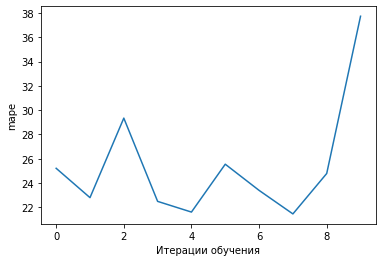

In [37]:
plt.plot(plot_mape)
plt.ylabel('mape')
plt.xlabel('Итерации обучения')
plt.show()

## Передача лучших параметров для обучения

In [38]:
lgbm_assets = lgb.LGBMRegressor(
    bagging_fraction = best_assets['bagging_fraction'],
    feature_fraction = best_assets['feature_fraction'],
    learning_rate = best_assets['learning_rate'],
    min_child_samples = int(best_assets['min_child_samples']),
    n_estimators = int(best_assets['n_estimators']),
    num_leaves = int(best_assets['num_leaves']),
    
    num_threads = -1,
    objective = 'poisson',
    min_data_per_group = 3,
    reg_sqrt = True,
    bagging_freq = 5,
    boost_from_average = True,
    seed = 42)

In [39]:
df[feachers]

,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб,Текущий месяц
0,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,1.0
5038,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,4.0
10076,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,7.0
15114,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,10.0
20152,26,361883,57.910126,59.981285,2,41158.0,78.0,3210324.0,10258.333333,13.0
...,...,...,...,...,...,...,...,...,...,...
5037,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,1.0
10075,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,4.0
15113,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,7.0
20151,29,1154000,54.984857,73.367452,3,30064.0,197.0,5922608.0,9575.714286,11.0


## Обучение 

In [40]:
regressor_assets = lgbm_assets.fit(
    df[feachers],
    df['Переоценка стоимости руб']
)

[LightGBM] [Warning] feature_fraction is set=0.54, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


## Shap

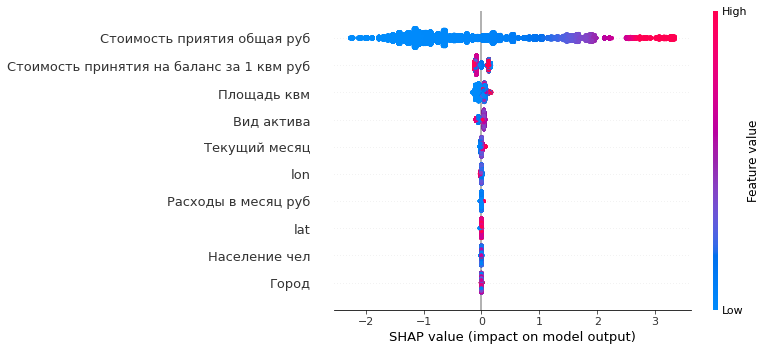

In [41]:
shap.initjs()
plt.figure(figsize=(15,15))
explainer = shap.TreeExplainer(regressor_assets)
shap_values = explainer.shap_values(df[feachers])
fig = shap.summary_plot(shap_values, df[feachers], 
                        show=False, 
                        max_display=25)

# Часть 2

## Прогноз стоимости актива через n месяцев с учетом изменения стоимости в регионах  

In [42]:
feachers = list(df.columns[1:-3])
feachers.remove('Текущий месяц')

In [43]:
## Заполняем поля

df_show = pd.DataFrame()

df_show['Город'] = ['Казань']
df_show['Город'] = le_city.transform(df_show['Город'])

df_show['Население чел'] = [1216965.0]
df_show['lat'] = [55.7943584]
df_show['lon'] = [49.1114975]
df_show['Вид актива'] = ['Квартира 3-х комнатная']
df_show['Вид актива'] = le_ac.transform(df_show['Вид актива'])

df_show['Стоимость принятия на баланс за 1 квм руб'] = [60000.0]
df_show['Площадь квм'] = [69.0]
df_show['Стоимость приятия общая руб'] = [4140000.0]
df_show['Расходы в месяц руб'] = [12000.0]
df_show['Текущий месяц'] = [12.0] 

In [44]:
df_show.head()

,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб,Текущий месяц
0,13,1216965.0,55.794358,49.111497,2,60000.0,69.0,4140000.0,12000.0,12.0


In [45]:
df_show['Срок нахождения на балансе, мес.'] = regressor_period.predict(df_show[feachers])
df_show['Стоимость реализации, руб.'] = regressor_assets.predict(df_show[feachers + ['Текущий месяц']])
df_show['Всего расходов, руб.'] = df_show['Расходы в месяц руб'] * df_show['Срок нахождения на балансе, мес.']

In [46]:
df_show.head()

,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб,Текущий месяц,"Срок нахождения на балансе, мес.","Стоимость реализации, руб.","Всего расходов, руб."
0,13,1216965.0,55.794358,49.111497,2,60000.0,69.0,4140000.0,12000.0,12.0,13.215034,4.730599e+06,158580.410081


## Часть 3

In [47]:
feachers = list(df.columns[1:-3])
feachers.remove('Текущий месяц')

## Заполняем данные по активу

In [48]:
df_show = pd.DataFrame()

df_show['Город'] = ['Казань']
df_show['Город'] = le_city.transform(df_show['Город'])

df_show['Население чел'] = [1216965.0]
df_show['lat'] = [55.7943584]
df_show['lon'] = [49.1114975]
df_show['Вид актива'] = ['Квартира 3-х комнатная']
df_show['Вид актива'] = le_ac.transform(df_show['Вид актива'])

df_show['Стоимость принятия на баланс за 1 квм руб'] = [60000.0]
df_show['Площадь квм'] = [69.0]
df_show['Стоимость приятия общая руб'] = [4140000.0]
df_show['Расходы в месяц руб'] = [12000.0]
df_show['Текущий месяц'] = [12.0] 

In [49]:
df_show[feachers]

,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб
0,13,1216965.0,55.794358,49.111497,2,60000.0,69.0,4140000.0,12000.0


In [50]:
df_show['Срок нахождения на балансе, мес.'] = regressor_period.predict(df_show[feachers])
df_show['Стоимость реализации, руб.'] = regressor_assets.predict(df_show[feachers + ['Текущий месяц']])
df_show['Всего расходов, руб.'] = df_show['Расходы в месяц руб'] * df_show['Срок нахождения на балансе, мес.']

In [51]:
def discounting(x, inflation=12):
    
    months = x[9]
    
    inflation = 1 + inflation / 100
    disc = (1 / inflation) ** (months / 12 )
    
    num = x[11]
    
    return num * disc

df_show['Дисконтирование цены'] = df_show.apply(discounting, axis = 1)

In [52]:
df_show['Скидка'] = df_show['Стоимость реализации, руб.'] - df_show['Дисконтирование цены']

In [53]:
df_show

,Город,Население чел,lat,lon,Вид актива,Стоимость принятия на баланс за 1 квм руб,Площадь квм,Стоимость приятия общая руб,Расходы в месяц руб,Текущий месяц,"Срок нахождения на балансе, мес.","Стоимость реализации, руб.","Всего расходов, руб.",Дисконтирование цены,Скидка
0,13,1216965.0,55.794358,49.111497,2,60000.0,69.0,4140000.0,12000.0,12.0,13.215034,4.730599e+06,158580.410081,4.223749e+06,506849.905111
